In [1]:
import scanpy as sc
import numpy as np
from umap import UMAP
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
data = sc.read('Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad')
data.X = normalize(data.X)
data.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [3]:
data.obs

,Admission,ClusterID,DPS,DTF,Donor_full,HLA1,IFN1,Sex,Status,Ventilated,...,nCount_RNA,nCount_SCT,nFeature_RNA,nFeature_SCT,percent_mt,percent_rpl,percent_rps,percent_rrna,seurat_clusters,singler
covid_555_1.1,ICU,13,9,9,C1 A,-0.026053,0.015625,M,COVID,NonVent,...,1222.0,1682.0,125,126,1.309329,0.245499,0.081833,46.644844,12,Erythroblast
covid_555_1.2,ICU,10,9,9,C1 A,0.023525,-0.000322,M,COVID,NonVent,...,1099.0,1700.0,160,160,13.102820,0.363967,0.363967,58.780708,9,B_cell
covid_555_1.3,ICU,19,9,9,C1 A,-0.044271,0.086385,M,COVID,NonVent,...,1055.0,1661.0,212,213,2.938389,0.947867,0.663507,55.829384,18,B_cell
covid_555_1.7,ICU,10,9,9,C1 A,-0.038040,0.022590,M,COVID,NonVent,...,2411.0,1971.0,312,312,10.908337,0.165906,0.041477,67.399422,9,B_cell
covid_555_1.8,ICU,22,9,9,C1 A,-0.043605,0.010739,M,COVID,NonVent,...,2276.0,1948.0,336,336,11.203866,0.307557,0.263620,67.355011,21,B_cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HIP045.2543,N/A,7,0,0,H6,0.588374,0.092001,M,Healthy,Healthy,...,6103.0,1959.0,2460,1080,6.898247,3.637555,2.867442,10.797968,6,Monocyte
HIP045.2544,N/A,21,0,0,H6,1.295145,0.045697,M,Healthy,Healthy,...,7324.0,2088.0,2488,1031,6.485527,6.157837,4.929000,12.738940,20,Monocyte
HIP045.2545,N/A,21,0,0,H6,0.892457,0.062819,M,Healthy,Healthy,...,6368.0,1929.0,2511,1021,4.742462,6.171483,4.978015,14.400126,20,T_cells
HIP045.2546,N/A,11,0,0,H6,0.020954,0.036953,M,Healthy,Healthy,...,6669.0,1918.0,2650,1063,4.573400,3.328835,2.998950,14.574899,10,Monocyte


In [4]:
splitter = KFold(shuffle=True)
train_idcs, test_idcs = next(splitter.split(data))
training, test = data.X[train_idcs], data.X[test_idcs]
trainobs = data.obs.copy()
trainobs.index = range(len(trainobs))
trainobs, testobs = trainobs.loc[train_idcs], trainobs.loc[test_idcs]

In [5]:
reducer = UMAP().fit(training)

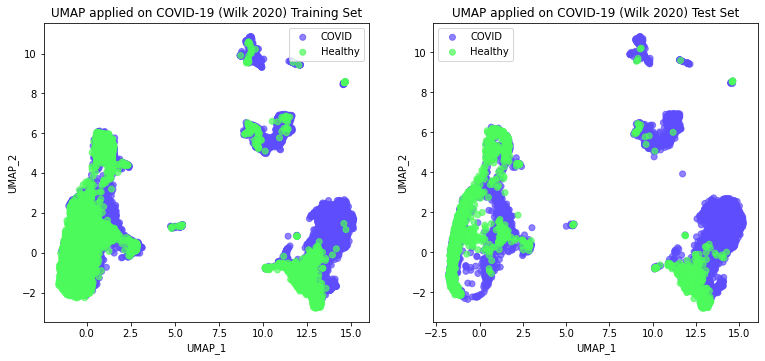

In [6]:
fig, canv = plt.subplots(1, 2, figsize=(12.8, 5.5))

colours = ["#5e4dfd", "#4cfc5b"]
train_trans = reducer.transform(training)
for i, status in np.ndenumerate(np.unique(trainobs['Status'])):
    canv[0].scatter(
        train_trans[trainobs['Status'] == status, 0], # first column as X
        train_trans[trainobs['Status'] == status, 1], # second column as Y
        alpha=.7,
        c=np.repeat(colours[i[0]], len(trainobs[trainobs['Status'] == status]))
    ).set_label(status)
canv[0].legend()
canv[0].set_xlabel("UMAP_1")
canv[0].set_ylabel("UMAP_2")
canv[0].set_title("UMAP applied on COVID-19 (Wilk 2020) Training Set")

test_trans = reducer.transform(test)
for i, status in np.ndenumerate(np.unique(testobs['Status'])):
    canv[1].scatter(
        test_trans[testobs['Status'] == status, 0], # first column as X
        test_trans[testobs['Status'] == status, 1], # second column as Y
        alpha=.7,
        c=np.repeat(colours[i[0]], len(testobs[testobs['Status'] == status]))
    ).set_label(status)
canv[1].legend()
canv[1].set_xlabel("UMAP_1")
canv[1].set_ylabel("UMAP_2")
canv[1].set_title("UMAP applied on COVID-19 (Wilk 2020) Test Set");

plt.show()

---------

In [7]:
classifier = RandomForestClassifier().fit(training, trainobs['Status'])

In [8]:
classifier.predict(test)

array(['COVID', 'COVID', 'COVID', ..., 'Healthy', 'Healthy', 'Healthy'],
      dtype=object)

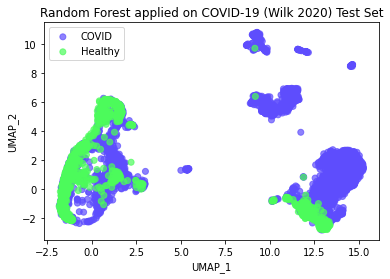

In [9]:
prediction = classifier.predict(test)
for i, status in np.ndenumerate(np.unique(prediction)):
    plt.scatter(
        test_trans[prediction == status, 0], # first column as X
        test_trans[prediction == status, 1], # second column as Y
        alpha=.7,
        c=np.repeat(colours[i[0]], len(testobs[prediction == status])),
    ).set_label(status)
plt.legend()
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")
plt.title("Random Forest applied on COVID-19 (Wilk 2020) Test Set");

In [10]:
print(f"Accuracy: {metrics.accuracy_score(testobs['Status'].values, prediction)}")
print(f"MMC: {metrics.matthews_corrcoef(testobs['Status'].values, prediction)}")

Accuracy: 0.9113471212968138
MMC: 0.8100444086855774


In [11]:
classifier = SGDClassifier().fit(training, trainobs['Status'])

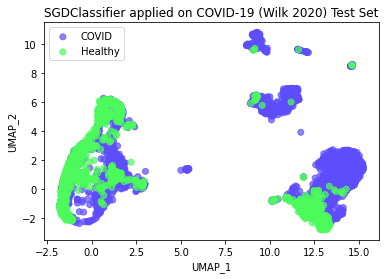

In [12]:
prediction = classifier.predict(test)
for i, status in np.ndenumerate(np.unique(prediction)):
    plt.scatter(
        test_trans[prediction == status, 0], # first column as X
        test_trans[prediction == status, 1], # second column as Y
        alpha=.7,
        c=np.repeat(colours[i[0]], len(testobs[prediction == status])),
    ).set_label(status)
plt.legend()
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")
plt.title("SGDClassifier applied on COVID-19 (Wilk 2020) Test Set");

In [13]:
print(f"Accuracy: {metrics.accuracy_score(testobs['Status'].values, prediction)}")
print(f"MMC: {metrics.matthews_corrcoef(testobs['Status'].values, prediction)}")

Accuracy: 0.972945779765232
MMC: 0.9424706315533168
